# 束搜索
:label:`sec_beam-search`

在 :numref:`sec_seq2seq`中，我们逐个预测输出序列，
直到预测序列中出现特定的序列结束词元“&lt;eos&gt;”。  
本节将首先介绍*贪心搜索*（greedy search）策略，
并探讨其存在的问题，然后对比其他替代策略：
*穷举搜索*（exhaustive search）和*束搜索*（beam search）。

在正式介绍贪心搜索之前，我们使用与 :numref:`sec_seq2seq`中
相同的数学符号定义搜索问题。  
在任意时间步$t'$，解码器输出$y_{t'}$的概率取决于
时间步$t'$之前的输出子序列$y_1, \ldots, y_{t'-1}$
和对输入序列的信息进行编码得到的上下文变量$\mathbf{c}$。  
为了量化计算代价，用$\mathcal{Y}$表示输出词表，
其中包含“&lt;eos&gt;”，
所以这个词汇集合的基数$\left|\mathcal{Y}\right|$就是词表的大小。
我们还将输出序列的最大词元数指定为$T'$。  
因此，我们的目标是从所有$\mathcal{O}(\left|\mathcal{Y}\right|^{T'})$个
可能的输出序列中寻找理想的输出。  
当然，对于所有输出序列，在“&lt;eos&gt;”之后的部分（非本句）
将在实际输出中丢弃。

## 贪心搜索

首先，让我们看看一个简单的策略：*贪心搜索*，
该策略已用于 :numref:`sec_seq2seq`的序列预测。  
对于输出序列的每一时间步$t'$，
我们都将基于贪心搜索从$\mathcal{Y}$中找到具有最高条件概率的词元，即：

$$y_{t'} = \operatorname*{argmax}_{y \in \mathcal{Y}} P(y \mid y_1, \ldots, y_{t'-1}, \mathbf{c})$$

一旦输出序列包含了“&lt;eos&gt;”或者达到其最大长度$T'$，则输出完成。

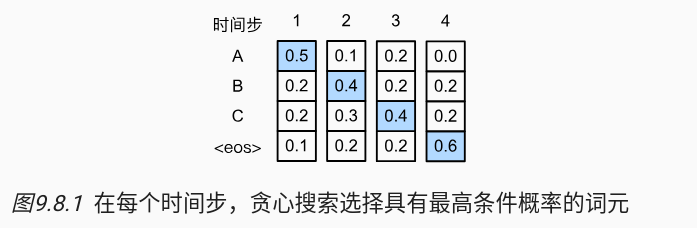

如 :numref:`fig_s2s-prob1`中，
假设输出中有四个词元“A”“B”“C”和“&lt;eos&gt;”。  
每个时间步下的四个数字分别表示在该时间步
生成“A”“B”“C”和“&lt;eos&gt;”的条件概率。  
在每个时间步，贪心搜索选择具有最高条件概率的词元。
因此，将在 :numref:`fig_s2s-prob1`中
预测输出序列“A”“B”“C”和“&lt;eos&gt;”。  
这个输出序列的条件概率是
$0.5\times0.4\times0.4\times0.6 = 0.048$。

那么贪心搜索存在的问题是什么呢？
现实中，*最优序列*（optimal sequence）应该是最大化
$\prod_{t'=1}^{T'} P(y_{t'} \mid y_1, \ldots, y_{t'-1}, \mathbf{c})$
值的输出序列，这是基于输入序列生成输出序列的条件概率。  
然而，贪心搜索无法保证得到最优序列。

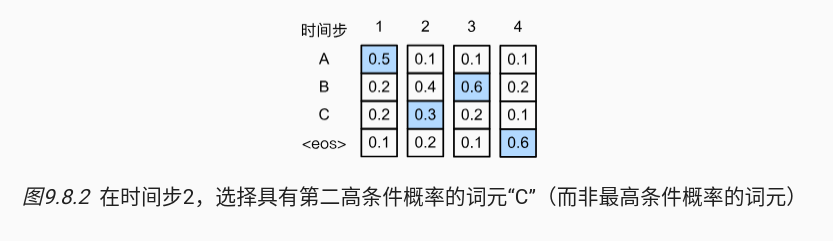

 :numref:`fig_s2s-prob2`中的另一个例子阐述了这个问题。  
与 :numref:`fig_s2s-prob1`不同，在时间步$2$中，
我们选择 :numref:`fig_s2s-prob2`中的词元“C”，
它具有*第二*高的条件概率。  
由于时间步$3$所基于的时间步$1$和$2$处的输出子序列已从
 :numref:`fig_s2s-prob1`中的“A”和“B”改变为
 :numref:`fig_s2s-prob2`中的“A”和“C”，
因此时间步$3$处的每个词元的条件概率也在 :numref:`fig_s2s-prob2`中改变。  
假设我们在时间步$3$选择词元“B”，
于是当前的时间步$4$基于前三个时间步的输出子序列“A”“C”和“B”为条件，
这与 :numref:`fig_s2s-prob1`中的“A”“B”和“C”不同。  
因此，在 :numref:`fig_s2s-prob2`中的时间步$4$生成
每个词元的条件概率也不同于 :numref:`fig_s2s-prob1`中的条件概率。  
结果， :numref:`fig_s2s-prob2`中的输出序列
“A”“C”“B”和“&lt;eos&gt;”的条件概率为
$0.5\times0.3 \times0.6\times0.6=0.054$，
这大于 :numref:`fig_s2s-prob1`中的贪心搜索的条件概率。  
这个例子说明：贪心搜索获得的输出序列
“A”“B”“C”和“&lt;eos&gt;”
不一定是最佳序列。

## 穷举搜索

如果目标是获得最优序列，
我们可以考虑使用*穷举搜索*（exhaustive search）：
穷举地列举所有可能的输出序列及其条件概率，
然后计算输出条件概率最高的一个。

虽然我们可以使用穷举搜索来获得最优序列，
但其计算量$\mathcal{O}(\left|\mathcal{Y}\right|^{T'})$可能高的惊人。
例如，当$|\mathcal{Y}|=10000$和$T'=10$时，
我们需要评估$10000^{10} = 10^{40}$序列，
这是一个极大的数，现有的计算机几乎不可能计算它。
然而，贪心搜索的计算量
$\mathcal{O}(\left|\mathcal{Y}\right|T')$
通它要显著地小于穷举搜索。
例如，当$|\mathcal{Y}|=10000$和$T'=10$时，
我们只需要评估$10000\times10=10^5$个序列。

## 束搜索

那么该选取哪种序列搜索策略呢？
如果精度最重要，则显然是穷举搜索。
如果计算成本最重要，则显然是贪心搜索。
而束搜索的实际应用则介于这两个极端之间。

*束搜索*（beam search）是贪心搜索的一个改进版本。
它有一个超参数，名为*束宽*（beam size）$k$。
在时间步$1$，我们选择具有最高条件概率的$k$个词元。
这$k$个词元将分别是$k$个候选输出序列的第一个词元。
在随后的每个时间步，基于上一时间步的$k$个候选输出序列，
我们将继续从$k\left|\mathcal{Y}\right|$个可能的选择中
挑出具有最高条件概率的$k$个候选输出序列。

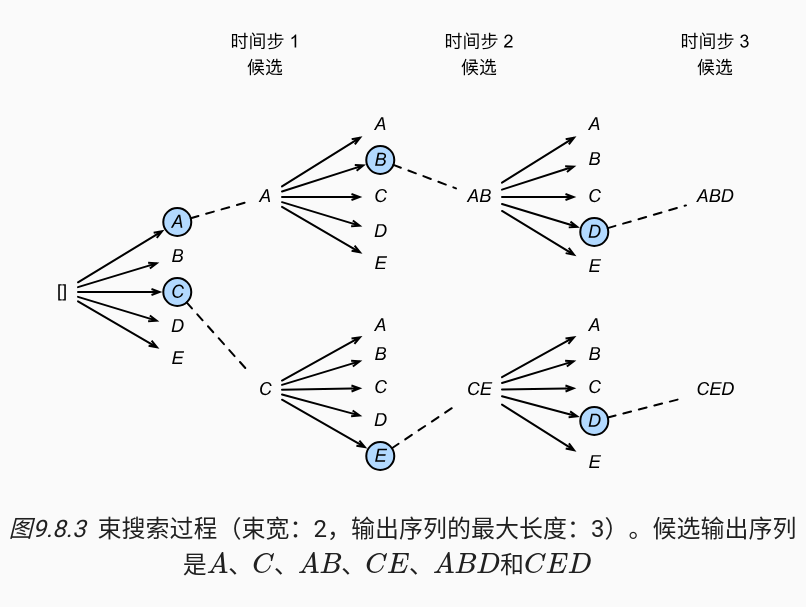

 :numref:`fig_beam-search`演示了束搜索的过程。
假设输出的词表只包含五个元素：
$\mathcal{Y} = \{A, B, C, D, E\}$，
其中有一个是“&lt;eos&gt;”。  
设置束宽为$2$，输出序列的最大长度为$3$。
在时间步$1$，假设具有最高条件概率
$P(y_1 \mid \mathbf{c})$的词元是$A$和$C$。  
在时间步$2$，我们计算所有$y_2 \in \mathcal{Y}$为：

$$\begin{aligned}
P(A, y_2 \mid \mathbf{c}) = P(A \mid \mathbf{c})P(y_2 \mid A, \mathbf{c}),
\\ P(C, y_2 \mid \mathbf{c}) = P(C \mid \mathbf{c})P(y_2 \mid C, \mathbf{c})
\end{aligned}$$

从这十个值中选择最大的两个，
比如$P(A, B \mid \mathbf{c})$和$P(C, E \mid \mathbf{c})$。  
然后在时间步$3$，我们计算所有$y_3 \in \mathcal{Y}$为：

$$\begin{aligned}
P(A, B, y_3 \mid \mathbf{c}) = P(A, B \mid \mathbf{c})P(y_3 \mid A, B, \mathbf{c}),
\\P(C, E, y_3 \mid \mathbf{c}) = P(C, E \mid \mathbf{c})P(y_3 \mid C, E, \mathbf{c}),
\end{aligned}$$ 

从这十个值中选择最大的两个，
即$P(A, B, D \mid \mathbf{c})$和$P(C, E, D \mid  \mathbf{c})$，  
我们会得到六个候选输出序列：
（1）$A$；（2）$C$；（3）$A,B$；（4）$C,E$；（5）$A,B,D$；（6）$C,E,D$。

最后，基于这六个序列（例如，丢弃包括“&lt;eos&gt;”和之后的部分），
我们获得最终候选输出序列集合。  
然后我们选择其中条件概率乘积最高的序列作为输出序列：

$$ \frac{1}{L^\alpha} \log P(y_1, \ldots, y_{L}\mid \mathbf{c}) = \frac{1}{L^\alpha} \sum_{t'=1}^L \log P(y_{t'} \mid y_1, \ldots, y_{t'-1}, \mathbf{c}),$$
:eqlabel:`eq_beam-search-score`

其中$L$是最终候选序列的长度，
$\alpha$通常设置为$0.75$。  
因为一个较长的序列在 :eqref:`eq_beam-search-score`
的求和中会有更多的对数项，
因此分母中的$L^\alpha$用于惩罚长序列。

束搜索的计算量为$\mathcal{O}(k\left|\mathcal{Y}\right|T')$，
这个结果介于贪心搜索和穷举搜索之间。  
实际上，贪心搜索可以看作一种束宽为$1$的特殊类型的束搜索。  
通过灵活地选择束宽，束搜索可以在正确率和计算代价之间进行权衡。

## 小结

* 序列搜索策略包括贪心搜索、穷举搜索和束搜索。
* 贪心搜索所选取序列的计算量最小，但精度相对较低。
* 穷举搜索所选取序列的精度最高，但计算量最大。
* 束搜索通过灵活选择束宽，在正确率和计算代价之间进行权衡。

## 练习

1. 我们可以把穷举搜索看作一种特殊的束搜索吗？为什么？
1. 在 :numref:`sec_seq2seq`的机器翻译问题中应用束搜索。
   束宽是如何影响预测的速度和结果的？
1. 在 :numref:`sec_rnn_scratch`中，我们基于用户提供的前缀，
   通过使用语言模型来生成文本。这个例子中使用了哪种搜索策略？可以改进吗？

[Discussions](https://discuss.d2l.ai/t/5768)
